In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)    
import matplotlib as mat
import matplotlib.pyplot as plt    
import seaborn as sns
import random
import os
import gc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import  LabelEncoder, RobustScaler , MinMaxScaler ,StandardScaler
import tensorflow as tf 
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow.keras.backend as K 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical ,plot_model
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense, Dropout, Input, InputLayer, Flatten 
from tensorflow.random import set_seed
set_seed(42)
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")


2025-08-18 18:43:04.768208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755542584.781649       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755542584.785746       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-18 18:43:04.801509: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has

ModuleNotFoundError: No module named 'keras.src.engine'

In [3]:
train_data = pd.read_csv("../input/tabular-playground-series-dec-2021/train.csv")
test_data= pd.read_csv("../input/tabular-playground-series-dec-2021/test.csv")
sample = pd.read_csv("../input/tabular-playground-series-dec-2021/sample_submission.csv")
train= train_data.drop('Id', axis=1) # drop unused id 
test= test_data.drop('Id', axis=1)


In [4]:
train.head(3)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2634,132,3,166,38,1247,251,210,119,3597,...,0,0,0,0,0,0,0,0,0,2
1,2769,89,5,633,10,626,177,209,178,-12,...,0,0,0,0,0,0,0,0,0,2
2,2749,46,30,127,239,2569,206,216,144,1899,...,0,0,0,0,0,0,0,0,0,2


In [5]:
train.describe().style.background_gradient(cmap='RdPu')


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000,3600000.000000
mean,2980.147353,151.572657,15.100498,271.276113,51.667899,1766.482904,211.838986,221.057635,140.813570,1581.520201,0.261214,0.041669,0.653581,0.021802,0.016907,0.030873,0.004294,0.037906,0.015722,0.007965,0.000000,0.002910,0.010854,0.054522,0.027965,0.018313,0.031281,0.014976,0.000000,0.015899,0.020667,0.013437,0.013798,0.017392,0.011544,0.031343,0.049171,0.025025,0.003259,0.013534,0.011778,0.010724,0.022253,0.028820,0.027506,0.037463,0.037860,0.012016,0.016042,0.010686,0.012199,0.040749,0.039242,0.031589,1.771544
std,289.044049,109.949721,8.546351,226.509966,68.225025,1315.660581,30.754979,22.233728,43.678945,1127.627133,0.439296,0.199832,0.475829,0.146037,0.128922,0.172974,0.065385,0.190968,0.124398,0.088891,0.000000,0.053868,0.103614,0.227044,0.164872,0.134082,0.174075,0.121455,0.000000,0.125084,0.142267,0.115139,0.116652,0.130728,0.106819,0.174243,0.216226,0.156201,0.056991,0.115545,0.107887,0.102998,0.147505,0.167301,0.163552,0.189892,0.190857,0.108959,0.125637,0.102817,0.109772,0.197709,0.194171,0.174904,0.894026
min,1773.000000,-33.000000,-3.000000,-82.000000,-317.000000,-287.000000,-4.000000,49.000000,-53.000000,-277.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2760.000000,60.000000,9.000000,110.000000,4.000000,822.000000,198.000000,210.000000,115.000000,781.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2966.000000,123.000000,14.000000,213.000000,31.000000,1436.000000,218.000000,224.000000,142.000000,1361.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [6]:
# variables variaition   
df_var=train.var().reset_index()
df_var.columns =['feature', 'variation']
df_var.sort_values("variation",ascending = True).T


,28,20,21,38,16,19,49,41,22,34,...,2,7,6,8,4,1,3,0,9,5
feature,Soil_Type15,Soil_Type7,Soil_Type8,Soil_Type25,Soil_Type3,Soil_Type6,Soil_Type36,Soil_Type28,Soil_Type9,Soil_Type21,...,Slope,Hillshade_Noon,Hillshade_9am,Hillshade_3pm,Vertical_Distance_To_Hydrology,Aspect,Horizontal_Distance_To_Hydrology,Elevation,Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways
variation,0.0,0.0,0.002902,0.003248,0.004275,0.007902,0.010571,0.010609,0.010736,0.01141,...,73.040118,494.338661,945.868705,1907.850195,4654.654063,12088.941145,51306.764721,83546.462297,1271542.950887,1730962.76505


In [7]:
# Correlation matrix
corrMatrix =train.corr(method='pearson', min_periods=1)
corrMatrix.style.background_gradient(axis=None)


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Elevation,1.000000,0.007723,-0.034458,0.033624,0.007746,0.171633,0.004607,0.014078,0.016486,0.088883,0.043044,0.083275,-0.001985,-0.362080,-0.020913,-0.042319,-0.084710,-0.025646,-0.005399,-0.074947,nan,-0.001485,0.000317,-0.106934,-0.009332,-0.003810,0.001569,-0.006776,nan,-0.000371,-0.016221,0.001152,0.002086,-0.003069,0.001772,0.019856,0.021555,0.006451,0.001018,-0.001921,-0.000998,-0.002487,0.002502,0.005255,0.009929,0.047743,0.013912,0.001297,0.000679,-0.002655,-0.004017,0.026237,0.020972,0.021036,-0.395488
Aspect,0.007723,1.000000,0.008262,-0.006336,0.002621,0.006001,-0.025073,0.022232,0.042705,-0.000165,-0.007675,0.000430,0.003216,-0.007003,-0.000164,-0.000164,0.004762,-0.000838,-0.001519,-0.001484,nan,0.000304,-0.000783,-0.003695,-0.001011,-0.002080,0.000350,0.001929,nan,0.000598,0.000957,0.002587,0.002399,-0.000103,-0.000565,-0.001070,0.000276,0.001478,0.000435,0.000609,-0.003893,-0.002833,-0.001093,0.000136,-0.000930,0.000525,-0.000012,0.003739,0.000233,0.001812,-0.000555,-0.000034,0.000961,0.002054,-0.002674
Slope,-0.034458,0.008262,1.000000,-0.006676,0.012943,-0.010584,-0.016850,-0.039290,-0.033653,-0.025390,-0.019861,-0.008240,0.033025,0.053799,0.003579,0.000935,0.017929,0.005727,0.001787,-0.008356,nan,0.001761,0.000429,0.021766,-0.004748,-0.000340,0.001503,0.003014,nan,-0.000510,-0.006028,0.003045,0.008672,-0.000610,-0.002636,-0.001251,-0.024911,0.000640,0.000047,0.004056,-0.001504,0.004917,0.004980,-0.002810,-0.004472,-0.022776,0.008414,-0.000228,-0.003300,0.001654,0.006115,-0.002385,-0.001008,0.001317,0.023242
Horizontal_Distance_To_Hydrology,0.033624,-0.006336,-0.006676,1.000000,0.015889,-0.006707,-0.002171,-0.003270,0.005020,0.000515,-0.016269,0.007136,0.011414,-0.024609,0.002197,0.002767,-0.007610,0.002616,0.006132,0.000051,nan,0.001461,0.004585,-0.000857,0.001648,0.002830,0.000893,0.002492,nan,0.002701,0.001590,0.002284,0.001068,0.002847,0.005070,0.005214,0.002466,0.000307,0.001660,0.004042,0.004516,0.006351,-0.011397,0.001297,0.000279,0.006914,0.003114,0.001955,0.003156,0.003572,0.002205,0.004853,0.003706,0.002965,0.012735
Vertical_Distance_To_Hydrology,0.007746,0.002621,0.012943,0.015889,1.000000,-0.008107,-0.000233,0.001573,-0.006756,-0.008002,-0.014157,-0.001344,0.001698,0.028717,0.002002,0.002251,0.003257,0.000698,-0.002325,0.003782,nan,0.002097,0.002170,0.008559,-0.000932,0.003910,0.001430,-0.001982,nan,0.001668,-0.003939,-0.000252,0.001272,-0.003059,0.002599,-0.003873,-0.016008,-0.000831,0.001315,0.002781,0.003699,0.001517,-0.001497,0.002021,0.000914,-0.000873,-0.001374,0.007382,-0.001336,0.004712,-0.000660,0.000385,0.000718,0.006491,0.033106
Horizontal_Distance_To_Roadways,0.171633,0.006001,-0.010584,-0.006707,-0.008107,1.000000,-0.001853,0.015658,0.015252,0.063698,0.050690,-0.020639,-0.013280,-0.114423,-0.006936,-0.017903,-0.038113,-0.009463,-0.002393,-0.014957,nan,0.002764,0.004120,-0.027565,-0.003207,-0.005910,0.000285,-0.003250,nan,0.003069,-0.002327,0.003045,0.001638,-0.004214,0.000327,-0.007396,-0.007886,-0.001782,0.001945,-0.001089,0.000835,0.000986,-0.001141,0.003731,-0.003839,-0.002781,-0.003903,0.002761,0.003060,0.002835,0.001649,0.016655,0.012574,0.010850,-0.093830
Hillshade_9am,0.004607,-0.025073,-0.016850,-0.002171,-0.000233,-0.001853,1.000000,0.000514,

In [8]:
cor_targ = train.corrwith(train["Cover_Type"]).reset_index()
cor_targ.columns =['feature', 'CorrelatioWithTarget']
cor_targ.sort_values('CorrelatioWithTarget',ascending = False).T


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,54,13,52,12,23,53,51,16,19,15,...,36,35,42,11,9,5,10,0,20,28
feature,Cover_Type,Wilderness_Area4,Soil_Type39,Wilderness_Area3,Soil_Type10,Soil_Type40,Soil_Type38,Soil_Type3,Soil_Type6,Soil_Type2,...,Soil_Type23,Soil_Type22,Soil_Type29,Wilderness_Area2,Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways,Wilderness_Area1,Elevation,Soil_Type7,Soil_Type15
CorrelatioWithTarget,1.0,0.250145,0.099145,0.093858,0.07352,0.053706,0.050721,0.048799,0.048252,0.036184,...,-0.023123,-0.026379,-0.031561,-0.044727,-0.069069,-0.09383,-0.117471,-0.395488,NaN,NaN


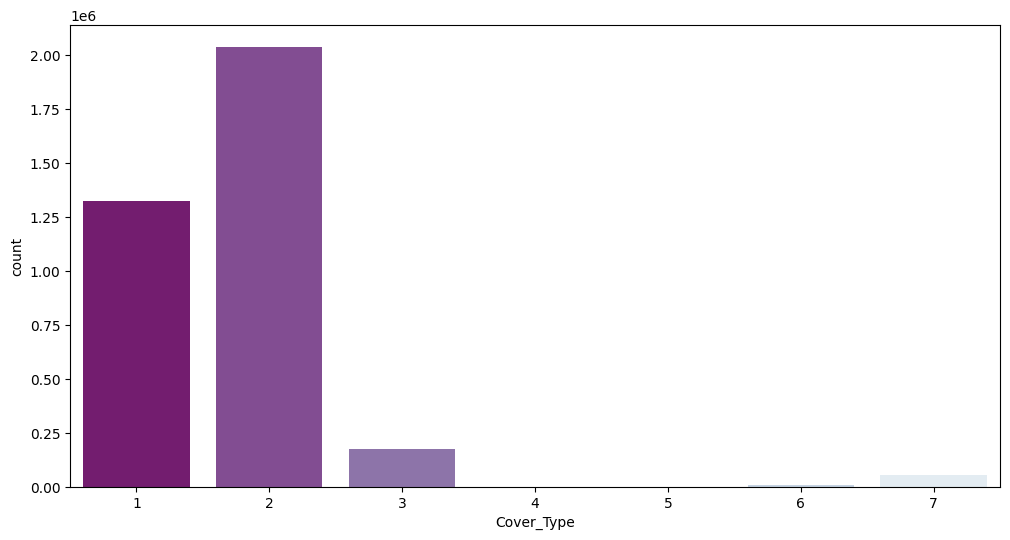

In [9]:
ax = plt.figure(figsize=(12, 6))
cover_type= train['Cover_Type'].value_counts().sort_index()
sns.barplot(x=cover_type.index, y=cover_type,palette="BuPu_r")
plt.show()


In [10]:
test.head(3)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,3135,92,33,356,77,1450,229,229,187,1611,...,0,0,0,0,0,0,0,0,0,0
1,3052,99,20,337,207,625,195,191,9,2293,...,0,0,0,0,0,0,0,0,0,0
2,3368,310,12,121,150,1547,222,236,106,335,...,0,0,0,0,0,0,0,0,0,0


In [11]:
test.describe().style.background_gradient(axis =1)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,2980.590418,151.702795,15.070890,271.669337,51.615117,1768.070160,211.824547,221.095690,140.786610,1580.386285,0.261008,0.041587,0.653505,0.021970,0.016255,0.031103,0.004112,0.037977,0.015655,0.008042,0.000000,0.002805,0.011248,0.054712,0.028170,0.018080,0.031427,0.014985,0.000000,0.015795,0.020715,0.013425,0.013930,0.017150,0.011498,0.031372,0.049165,0.024993,0.003255,0.013465,0.011652,0.010565,0.022460,0.029288,0.027380,0.037457,0.037470,0.011803,0.016158,0.010958,0.012287,0.040773,0.039212,0.031880
std,289.085283,110.063746,8.550118,226.906772,68.134441,1315.154364,30.804757,22.209785,43.875538,1127.518383,0.439185,0.199645,0.475854,0.146586,0.126455,0.173595,0.063997,0.191142,0.124137,0.089319,0.000000,0.052888,0.105456,0.227418,0.165459,0.133241,0.174470,0.121493,0.000000,0.124682,0.142429,0.115086,0.117201,0.129830,0.106608,0.174323,0.216213,0.156102,0.056960,0.115255,0.107316,0.102242,0.148174,0.168611,0.163188,0.189880,0.189911,0.107996,0.126081,0.104103,0.110166,0.197763,0.194100,0.175681
min,1777.000000,-29.000000,-3.000000,-92.000000,-288.000000,-257.000000,-1.000000,56.000000,-51.000000,-253.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2761.000000,60.000000,9.000000,111.000000,4.000000,824.000000,198.000000,210.000000,115.000000,779.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2967.000000,123.000000,14.000000,213.000000,31.000000,1438.000000,218.000000,224.000000,142.000000,1362.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

/tmp/ipykernel_8/3094301693.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[features].mean(axis=1),color="red", kde=True,bins=120, label='train')
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_8/3094301693.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `h

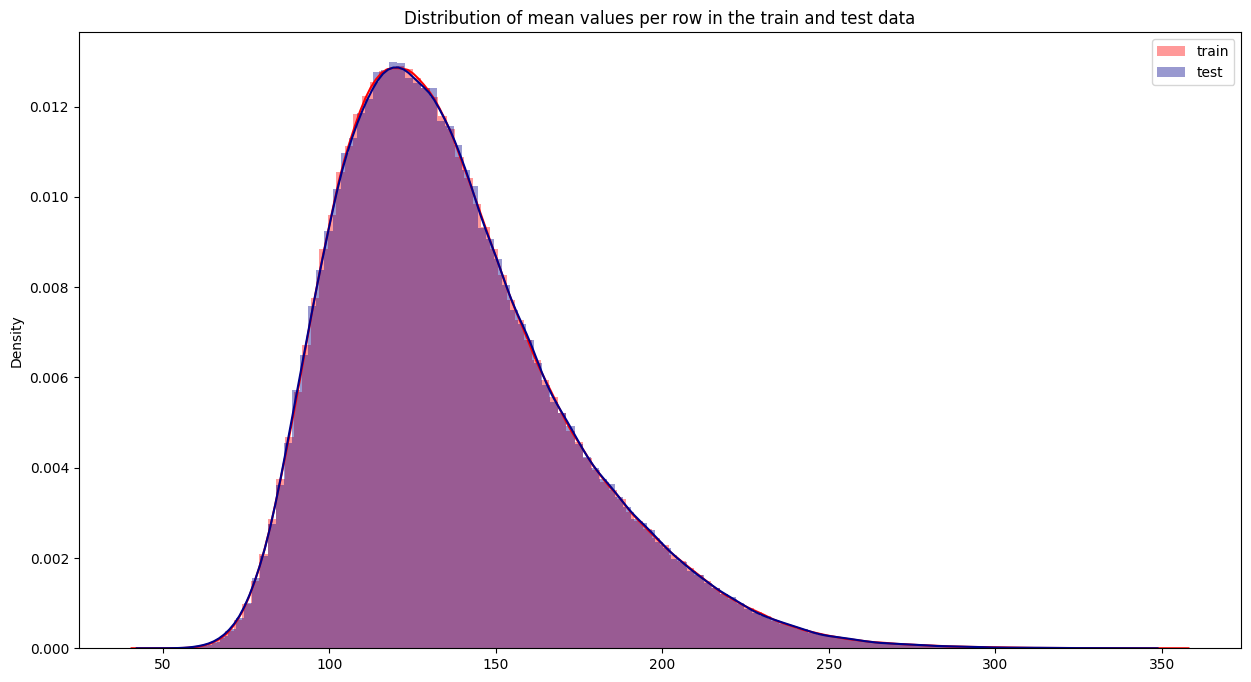

In [12]:
plt.figure(figsize=(15,8))
features = train.columns.values[0:54]
sns.distplot(train[features].mean(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=1),color="darkblue", kde=True,bins=120, label='test')
plt.title("Distribution of mean values per row in the train and test data")
plt.legend()
plt.show()


/tmp/ipykernel_8/4290723116.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[features].mean(axis=0),color="orange",kde=True,bins=120, label='train')
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_8/4290723116.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or 

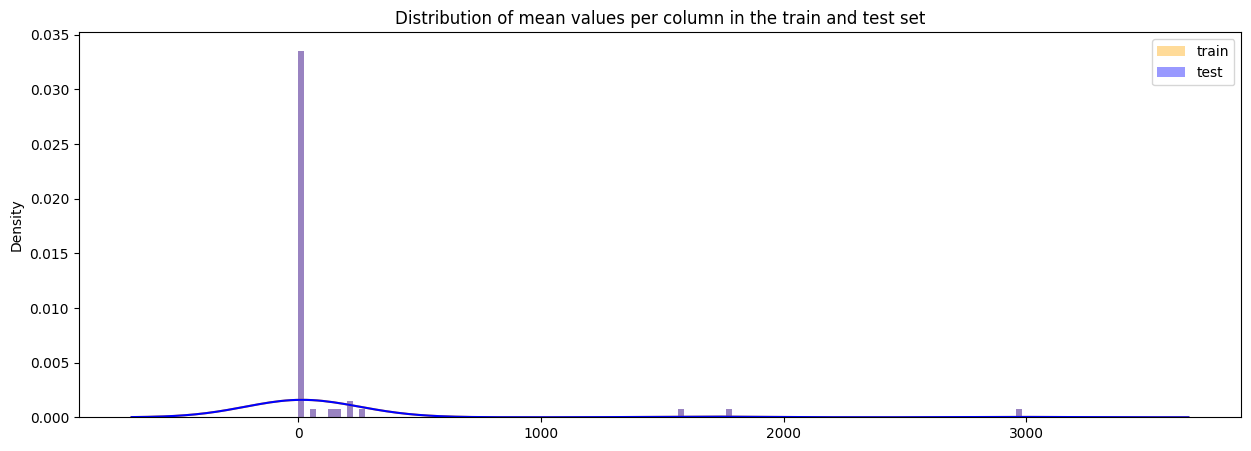

In [13]:
plt.figure(figsize=(15,5))
sns.distplot(train[features].mean(axis=0),color="orange",kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=0),color="blue", kde=True,bins=120, label='test')
plt.title("Distribution of mean values per column in the train and test set")
plt.legend()
plt.show()


/tmp/ipykernel_8/596922477.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[features].std(axis=1),color="#2F4F4F", kde=True,bins=120, label='train')
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_8/596922477.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `

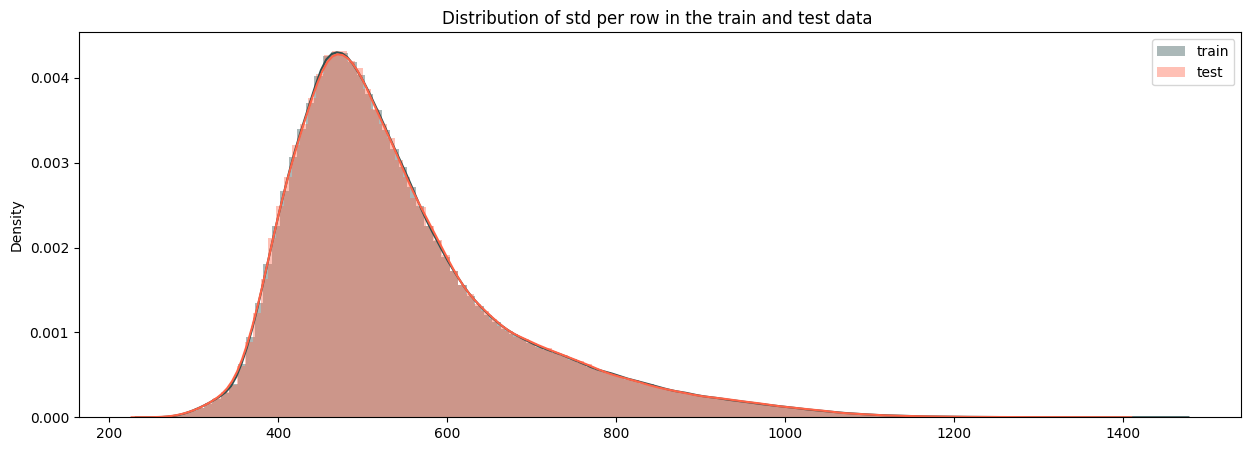

In [14]:
plt.figure(figsize=(15,5))
sns.distplot(train[features].std(axis=1),color="#2F4F4F", kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=1),color="#FF6347", kde=True,bins=120, label='test')
plt.title("Distribution of std per row in the train and test data ")
plt.legend()
plt.show()


/tmp/ipykernel_8/74821424.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[features].std(axis=0),color="#778899",kde=True,bins=120, label='train')
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_8/74821424.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `his

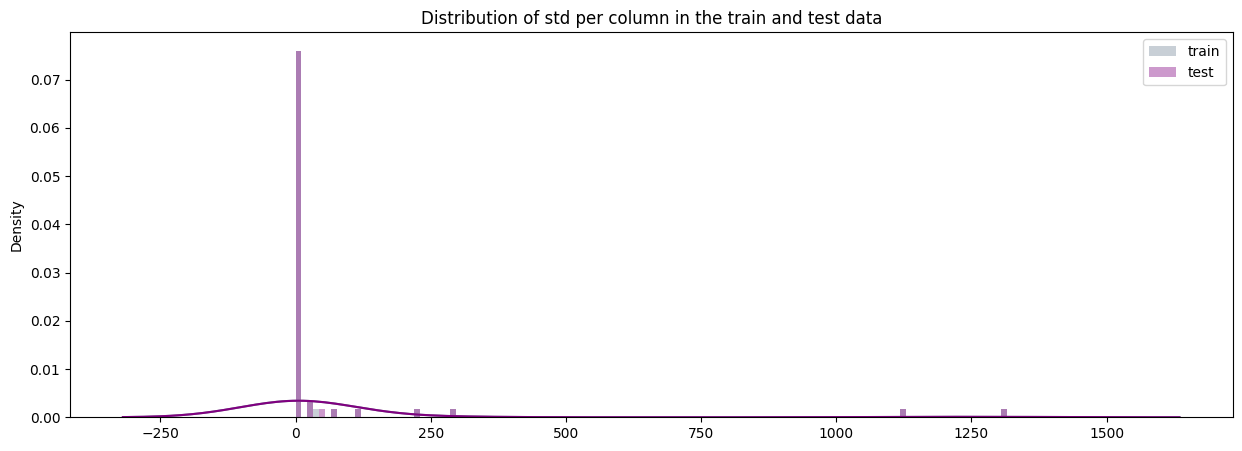

In [15]:
plt.figure(figsize=(15,5))
sns.distplot(train[features].std(axis=0),color="#778899",kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=0),color="#800080", kde=True,bins=120, label='test')
plt.title("Distribution of std per column in the train and test data")
plt.legend()
plt.show()


/tmp/ipykernel_8/2640626971.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,3,i)
/tmp/ipykernel_8/2640626971.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[col],color="yellow", kde=True,bins=100, label='train')
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_

<Figure size 640x480 with 0 Axes>

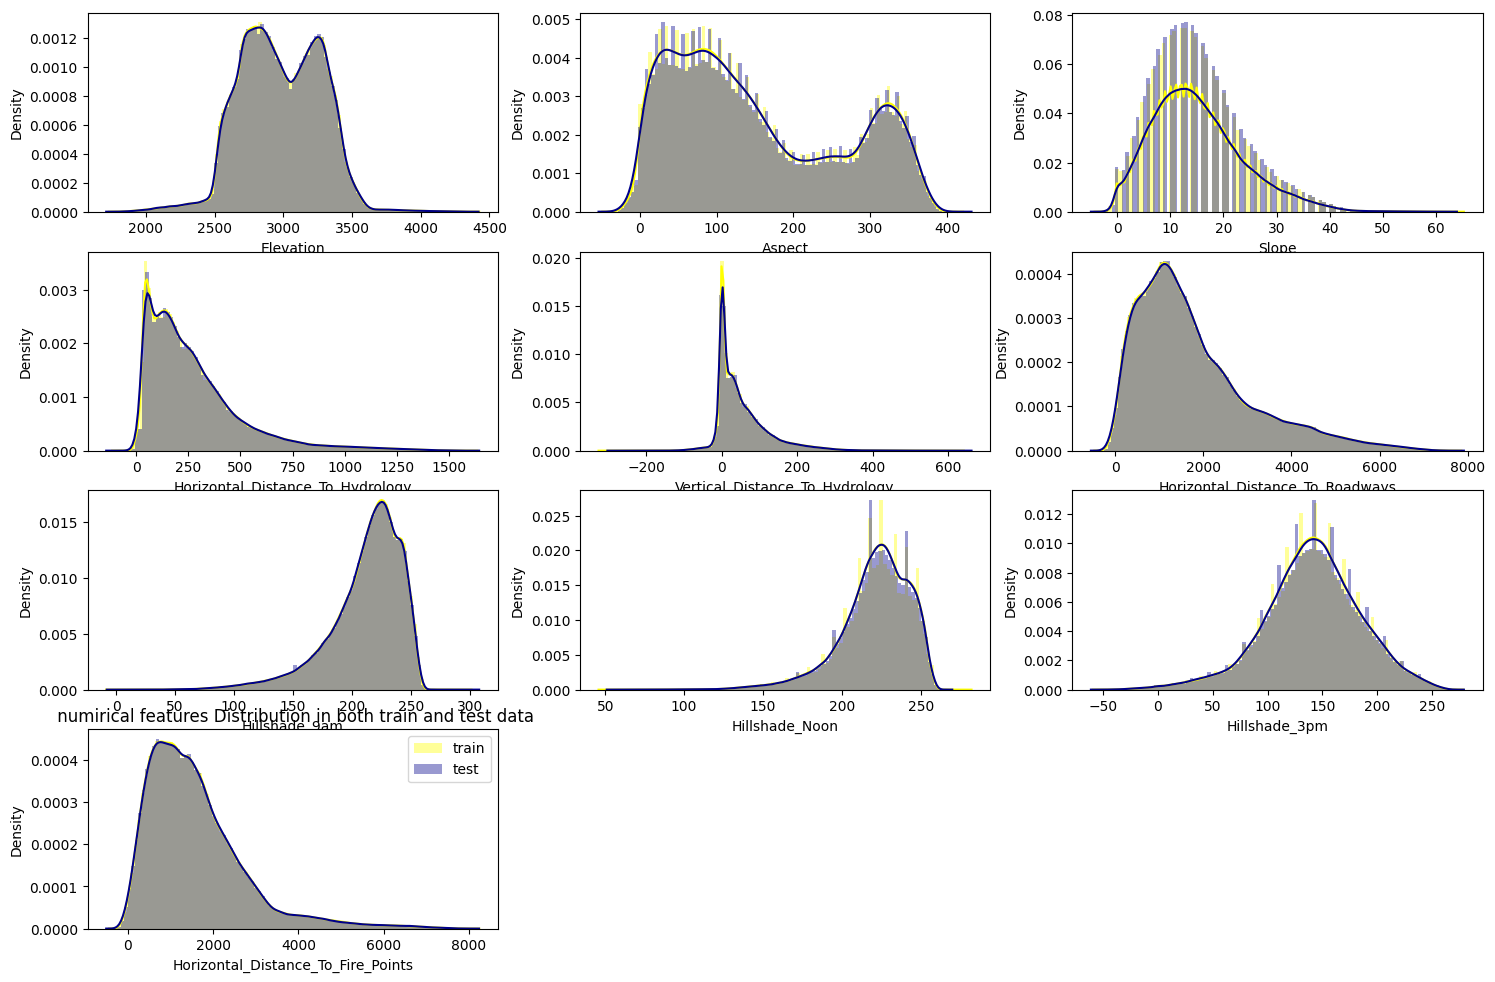

In [16]:
num_cols = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
     "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
]
i = 1
plt.figure()
fig, ax = plt.subplots(figsize=(18, 15))
for col in num_cols:
    plt.subplot(5,3,i)
    sns.distplot(train[col],color="yellow", kde=True,bins=100, label='train')
    sns.distplot(test[col],color="Darkblue", kde=True,bins=100, label='test')
    i += 1
plt.legend()
plt.title(" numirical features Distribution in both train and test data")  
plt.show()


In [17]:
# remove unuseful features
train = train.drop([ 'Soil_Type7', 'Soil_Type15','Soil_Type1'], axis=1)
test= test.drop(['Soil_Type7', 'Soil_Type15','Soil_Type1'], axis=1)


##### this is not really practical but improves your score by 0.002 ( maybe 0.003 lol ) 
# drop class 5 and claas 4 ,
train =train[train.Cover_Type != 5] 
train =train[train.Cover_Type != 4] 
#change cover type 4 to 3 check , https://www.kaggle.com/ambrosm/tpsdec21-12-eliminate-cover-type-4
#train.loc[train.Cover_Type == 4, 'Cover_Type'] = 3 


In [18]:
y_target = train["Cover_Type"].copy() ##target variable 
X_train = train.copy().drop("Cover_Type",axis = 1) ##train data 


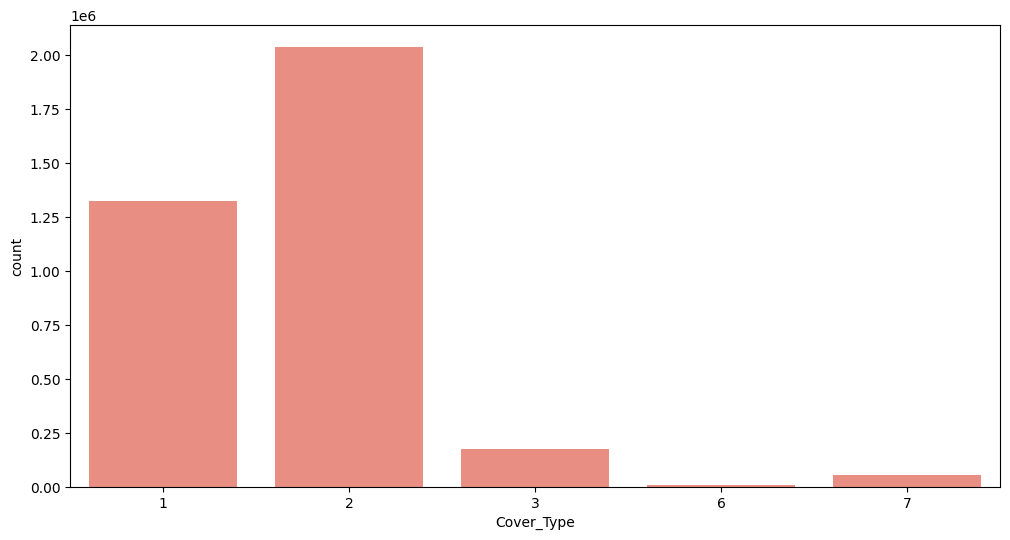

In [19]:
ax = plt.figure(figsize=(12, 6))
cover_type=y_target.value_counts().sort_index(ascending = False )
sns.barplot(x=cover_type.index,y=cover_type,color="salmon")
plt.show()


In [20]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max  np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max  np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max  np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max  np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df


SyntaxError: invalid syntax (575826225.py, line 13)

In [21]:
%%time
X_train = reduce_mem_usage(X_train)
test = reduce_mem_usage(test)


NameError: name 'reduce_mem_usage' is not defined

In [22]:
# i expriment it with skew abd sumù variable but it hurted the performance by -0.0003
#you can expriment with others using the same model or other models 

def stat_features(df):
    #df['f_mean'] = df.mean(axis=1)
    #df['f_std']  = df.std(axis=1)
    df['r_skew'] = df.skew(axis=1)
    df['r_sum'] = df.sum(axis=1)
    return df

#X_train = stat_features(train_df)
#test = stat_features(test_df)


In [23]:
### delet it 
del train_data 
del test_data 


In [24]:
num_cols = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
     "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
]


In [25]:
scaler =  StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
test[num_cols]= scaler.transform(test[num_cols])


/tmp/ipykernel_8/2780152866.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,i)
/tmp/ipykernel_8/2780152866.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train[col],color="yellow", kde=True, label='train')
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_8/2780152

<Figure size 640x480 with 0 Axes>

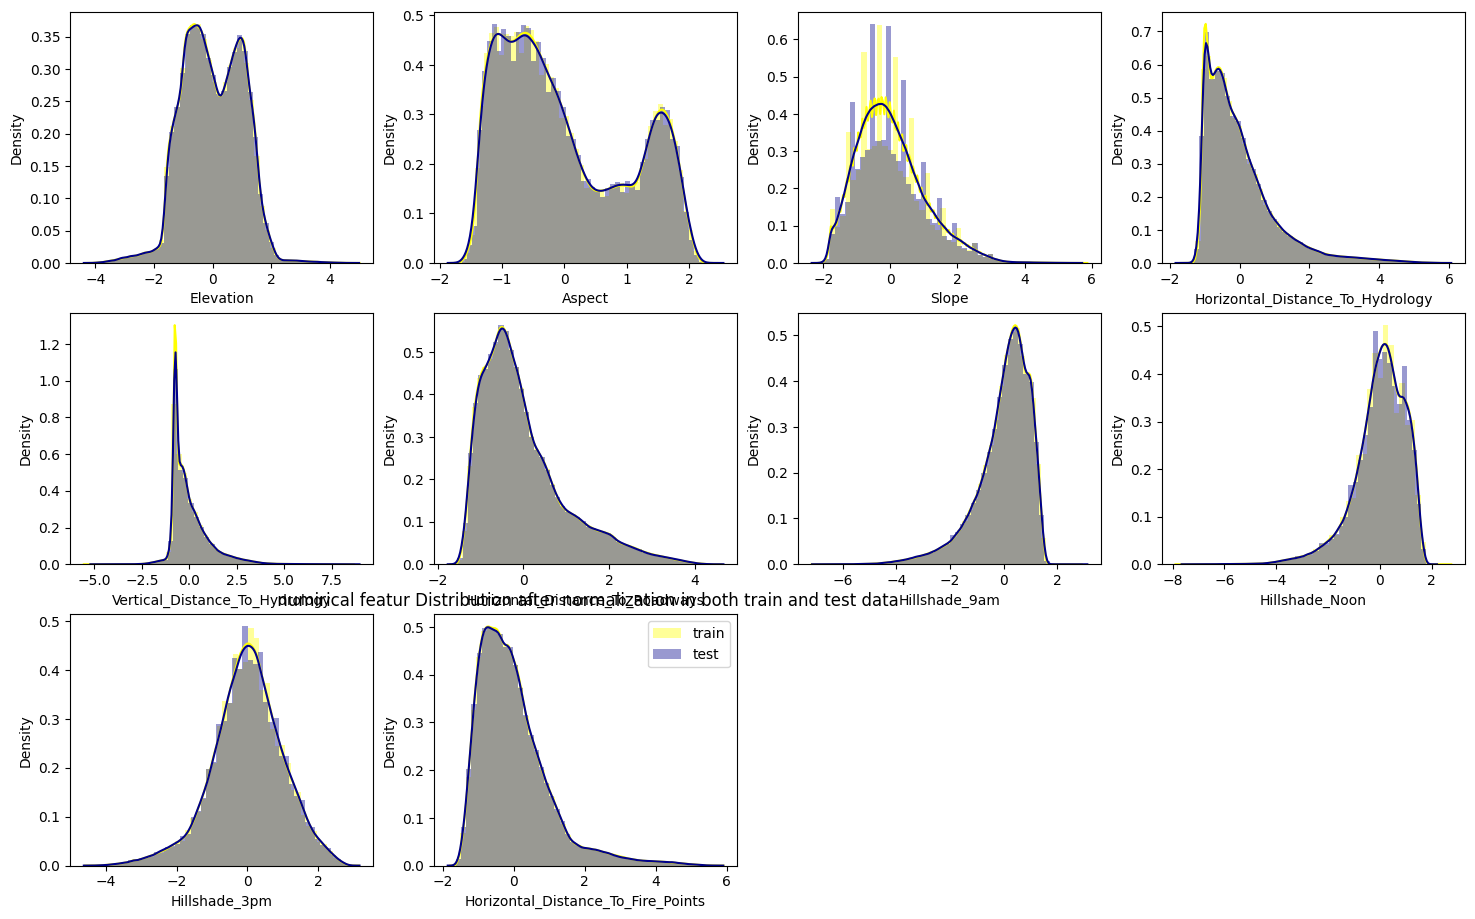

In [26]:
i = 1
plt.figure()
fig, ax = plt.subplots(figsize=(18, 15))
for col in num_cols:
    plt.subplot(4,4,i)
    sns.distplot(X_train[col],color="yellow", kde=True, label='train')
    sns.distplot(test[col],color="Darkblue", kde=True, label='test')
    i += 1
plt.legend()
plt.title(" numirical featur Distribution after normalization in both train and test data")  
plt.show()


In [27]:
### label encoder for target 
label_encod = LabelEncoder()
y_encoded =label_encod.fit_transform(y_target)
# categorical transofrm for target
#y_cat =to_categorical(y_encoded)


In [28]:
print(y_encoded.shape,y_target.shape,X_train.shape,test.shape )


(3599666,) (3599666,) (3599666, 51) (400000, 51)


In [29]:
n_classes = 5
def get_model(X_train):
    inputs = layers.Input(shape = (X_train.shape[1],))
    
    hidden = layers.Dense(units=350, kernel_initializer="lecun_normal", activation="selu")(inputs)
    flatten = layers.Flatten()(hidden)
    dropout = layers.Dropout(0.3)(flatten)
    hidden1 = tfa.layers.WeightNormalization(layers.Dense(units=128, activation='selu', kernel_initializer="he_normal"))(dropout)
    dropout1 = layers.Dropout(0.3)(layers.Concatenate()([hidden1, flatten]))
    hidden2 = tfa.layers.WeightNormalization(layers.Dense(units=64, activation='selu', kernel_initializer="he_normal"))(dropout1) 
    dropout2 = layers.Dropout(0.3)(layers.Concatenate()([hidden1,flatten, hidden2]))
    hidden3 = tfa.layers.WeightNormalization(layers.Dense(units=32, activation='selu', kernel_initializer="he_normal"))(dropout2) 
    dropout3 = layers.Dropout(0.3)(layers.Concatenate()([hidden3,dropout2, hidden2]))
    hidden4 = tfa.layers.WeightNormalization(layers.Dense(units=32, activation='selu', kernel_initializer="he_normal"))(dropout3) 

    # output layer 
    output = layers.Dense(n_classes, activation = 'softmax')(hidden4)
    #model 
    model = keras.Model(inputs=inputs, outputs=output, name="resnet_baseline")
    
    return model


In [30]:
##model parameters
early_stopping = callbacks.EarlyStopping(patience=10, min_delta=1e-5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor = 0.6, patience = 5, verbose = 0) 
optimizer = keras.optimizers.Adam()
metrics=['acc']
loss= "sparse_categorical_crossentropy"


NameError: name 'callbacks' is not defined

In [31]:
model = get_model(X_train)
model.compile(loss=loss, optimizer = optimizer, metrics=metrics)


NameError: name 'layers' is not defined

In [32]:
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True
)


NameError: name 'plot_model' is not defined

In [33]:
model.summary()


NameError: name 'model' is not defined

In [34]:
X_train= X_train.values
epoch = 50
batch_size = 2048
val_score = []
test_pred = np.zeros((1, 1))
N_F = 5  #use 5 folds
SKF= StratifiedKFold(n_splits=N_F, shuffle=True, random_state=42)
for fold, (idx_train, idx_valid) in enumerate(SKF.split(X_train,y_encoded)):
        X_tr, y_tr = X_train[idx_train], y_encoded[idx_train]
        X_val, y_val = X_train[idx_valid], y_encoded[idx_valid]
        K.clear_session()
        model = get_model(X_tr)
        model.compile(loss=loss, optimizer = optimizer, metrics=metrics)
        model.fit(X_tr, y_tr,
              batch_size = batch_size, epochs =epoch,
              validation_data=(X_val, y_val),
              callbacks=[early_stopping, reduce_lr], verbose=0)
        val_pred = np.argmax(model.predict(X_val), axis=1)
        score = accuracy_score(y_val, val_pred)
        val_score.append(score)
        test_pred = test_pred + model.predict(test)
        print(f"FOLD {fold:d}: validation accuracy is {score:.6f}")
        _ = gc.collect()
print ("**************************************************")
print(f"Mean Validation Accuracy is : {np.mean(val_score)}")


NameError: name 'K' is not defined

In [35]:
predictions = np.argmax(test_pred, axis=1)
predictions = label_encod.inverse_transform(predictions)


In [36]:
sample['Cover_Type'] = predictions
sample.to_csv('resnet.csv', index=False)
sample


ValueError: Length of values (1) does not match length of index (400000)